In [ ]:
import numpy as np, random, os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, backend as K

import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Load data

In [ ]:
dataset1 = 'datasets/FashionMNIST0.3.npz'
dataset2 = 'datasets/FashionMNIST0.6.npz'
dataset3 = 'datasets/CIFAR.npz'

data = np.load(dataset2)

print(data.keys())

Xtr = data['Xtr']
Str = data['Str']
Xts = data['Xts']
Yts = data['Yts']

print("Training data shape:", Xtr.shape)
print("Training labels shape:", Str.shape)
print("Test data shape:", Xts.shape)
print("Test labels shape:", Yts.shape)

KeysView(NpzFile 'datasets/FashionMNIST0.6.npz' with keys: Xtr, Str, Xts, Yts)
Training data shape: (18000, 784)
Training labels shape: (18000,)
Test data shape: (3000, 784)
Test labels shape: (3000,)


## Find CIFAR matrix

In [ ]:
def estimate_T_by_repeats(X, s, n_classes=3, R=10, seed=0):
    T_counts = np.zeros((n_classes, n_classes), dtype=float)
    for r in range(R):
        X_tr, X_va, s_tr, s_va = train_test_split(
            X, s, test_size=0.2, stratify=s, random_state=seed + r
        )
        clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=seed + r)
        y_hat = clf.fit(X_tr, s_tr).predict(X_va)

        for i in range(n_classes):
            mask = (y_hat == i)
            if mask.sum() == 0:
                T_counts[i] += 1.0
            else:
                T_counts[i] += np.bincount(s_va[mask], minlength=n_classes)

    T_counts += 1e-6
    T_hat = T_counts / T_counts.sum(axis=1, keepdims=True)
    return T_hat

In [ ]:
data = np.load(dataset1)
X = data['Xtr'].reshape(len(data['Xtr']), -1)
s = data['Str']

seed = 10086

T_hat1 = estimate_T_by_repeats(X, s, n_classes=3, R=10, seed=seed)
print(np.round(T_hat1, 1))

[[0.7 0.3 0. ]
 [0.  0.7 0.3]
 [0.3 0.  0.7]]


In [ ]:
data2 = np.load(dataset2)
X2 = data2['Xtr'].reshape(len(data2['Xtr']), -1)
s2 = data2['Str']

T_hat2 = estimate_T_by_repeats(X2, s2, n_classes=3, R=10, seed=seed)
print(np.round(T_hat2, 1))

[[0.4 0.3 0.3]
 [0.3 0.4 0.3]
 [0.3 0.3 0.4]]


In [ ]:
data3 = np.load(dataset3)
X3 = data3['Xtr'].reshape(len(data3['Xtr']), -1)
s3 = data3['Str']

T_hat3 = estimate_T_by_repeats(X3, s3, n_classes=3, R=10, seed=seed)
print(np.round(T_hat3, 1))

[[0.4 0.3 0.3]
 [0.3 0.4 0.3]
 [0.3 0.3 0.4]]


In [ ]:
T_hat1 = np.array([
    [0.7, 0.3, 0.0],
    [0.0, 0.7, 0.3],
    [0.3, 0.0, 0.7]
], dtype=np.float32)

T_hat2 = np.array([
    [0.4, 0.3, 0.3],
    [0.3, 0.4, 0.3],
    [0.3, 0.3, 0.4]
], dtype=np.float32)

T_hat3 = np.array([
    [0.4, 0.3, 0.3],
    [0.3, 0.4, 0.3],
    [0.3, 0.3, 0.4]
], dtype=np.float32)

## Basic model and runing function

In [ ]:
def training_model(loss, input_shape, num_classes, seed=10086):
    tf.keras.utils.set_random_seed(seed)
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    return model


In [ ]:
def load_npz_dataset(path):
    data = np.load(path)
    Xtr, Str = data['Xtr'], data['Str']
    Xts, Yts = data['Xts'], data['Yts']
    Xtr = Xtr.astype("float32") / 255.0
    Xts = Xts.astype("float32") / 255.0
    return Xtr, Str, Xts, Yts

In [ ]:
def run_model_on_dataset(dataset_path, T_matrix, model_kind, num_runs=10, seed=0, num_classes=3,
                         epochs=10, batch_size=128, verbose=0):
    accs = []
    Xtr, Str, Xts, Yts = load_npz_dataset(dataset_path)
    input_shape = Xtr.shape[1:]
    Yts_oh = to_categorical(Yts, num_classes=num_classes)

    for run in range(num_runs):
        X_train, X_val, S_train, S_val = train_test_split(
            Xtr, Str, test_size=0.2, stratify=Str, random_state=seed + run
        )
        S_train_oh = to_categorical(S_train, num_classes=num_classes)
        S_val_oh   = to_categorical(S_val,   num_classes=num_classes)

        callbacks = None

        if model_kind == 'base':
            loss_fn = tf.keras.losses.CategoricalCrossentropy()
        elif model_kind == 'forward':
            loss_fn = forward_correction_loss(T_matrix)
        elif model_kind == 'backward':
            loss_fn = backward_correction_loss(T_matrix)

        model = training_model(loss=loss_fn, input_shape=input_shape,
                               num_classes=num_classes, seed=seed+run)
        model.fit(
            X_train, S_train_oh,
            validation_data=(X_val, S_val_oh),
            epochs=epochs, batch_size=batch_size, verbose=verbose,
            callbacks=callbacks
        )

        loss, acc = model.evaluate(Xts, Yts_oh, verbose=0)
        accs.append(acc)

    accs = np.asarray(accs, dtype=float)
    return accs.mean(), accs.std(), accs

In [ ]:
def run_coteaching_model_on_dataset(dataset_path, T_matrix, *,
                                   num_runs=10, seed=0, num_classes=3,
                                   epochs=10, batch_size=128, Tk=10,
                                   verbose=0):

    Xtr, Str, Xts, Yts = load_npz_dataset(dataset_path)
    input_shape = Xtr.shape[1:]

    tau = _estimate_tau_from_T(T_matrix)

    accs = []
    for run in range(num_runs):
        X_train, X_val, S_train, S_val = train_test_split(
            Xtr, Str, test_size=0.2, stratify=Str, random_state=seed + run
        )
        S_train_oh = to_categorical(S_train, num_classes=num_classes)

        model_f = training_model(
            loss=tf.keras.losses.CategoricalCrossentropy(),
            input_shape=input_shape, num_classes=num_classes, seed=seed+run
        )
        model_g = training_model(
            loss=tf.keras.losses.CategoricalCrossentropy(),
            input_shape=input_shape, num_classes=num_classes, seed=seed+run+100
        )

        opt_f = tf.keras.optimizers.Adam()
        opt_g = tf.keras.optimizers.Adam()

        ds_train = tf.data.Dataset.from_tensor_slices((X_train, S_train_oh)) \
                                   .shuffle(len(X_train), seed=seed+run, reshuffle_each_iteration=True) \
                                   .batch(batch_size, drop_remainder=True)

        for ep in range(1, epochs+1):
            kr = _keep_rate(ep, tau, Tk=Tk)   # 0~1
            _coteach_train_epoch(ds_train, model_f, model_g, opt_f, opt_g, keep_rate=kr)

        pf = model_f.predict(Xts, verbose=verbose)
        pg = model_g.predict(Xts, verbose=verbose)
        y_pred = np.argmax((pf + pg)/2.0, axis=1)
        acc = (y_pred == Yts).mean()
        accs.append(float(acc))

    accs = np.asarray(accs, dtype=float)
    return accs.mean(), accs.std(), accs

## Loading data and matrix

In [ ]:
data1 = np.load(dataset1)
X1 = data1['Xtr'].reshape(len(data1['Xtr']), -1)
s1 = data1['Str']
data2 = np.load(dataset2)
X2 = data2['Xtr'].reshape(len(data2['Xtr']), -1)
s2 = data2['Str']
data3 = np.load(dataset3)
X3 = data3['Xtr'].reshape(len(data3['Xtr']), -1)
s3 = data3['Str']

In [ ]:
T_by_dataset_est = {
    'FashionMNIST0.3': T_hat1,
    'FashionMNIST0.6': T_hat2,
    'CIFAR': T_hat3,
}

## Set para

In [ ]:
NUM_RUNS = 10
EPOCHS   = 10
BATCH    = 128
SEED     = 2025

datasets = {
    'FashionMNIST0.3': dataset1,
    'FashionMNIST0.6': dataset2,
    'CIFAR': dataset3,
}

## Base

In [ ]:
results_base = []

for name, path in datasets.items():
    T_used = T_by_dataset_est[name]

    mean_b, std_b, _ = run_model_on_dataset(
        path, T_used, model_kind='base',
        num_runs=NUM_RUNS, seed=SEED,
        epochs=EPOCHS, batch_size=BATCH, verbose=0
    )
    results_base.append((name, 'Base', mean_b, std_b))

print("\n================= Summary: BASE only (NUM_RUNS={}, epochs={}) ================".format(NUM_RUNS, EPOCHS))
for (ds, mk, m, s) in results_base:
    print(f"{ds:<8} {mk:<8}  mean={m:.4f}  std={s:.4f}")



================= Summary: BASE only (NUM_RUNS=10, epochs=10) ================
FashionMNIST0.3 Base      mean=0.9258  std=0.0358
FashionMNIST0.6 Base      mean=0.6513  std=0.1002
CIFAR    Base      mean=0.4541  std=0.0657


## Forward

In [ ]:
def forward_correction_loss(T):
    T = tf.constant(T, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_pred_corrected = tf.matmul(y_pred, T)
        y_pred_corrected = tf.clip_by_value(y_pred_corrected, 1e-7, 1.0)
        return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred_corrected))
    return loss

In [ ]:
results_forward = []  # (dataset, 'Forward', mean, std)

for name, path in datasets.items():
    T_used = T_by_dataset_est[name]

    mean_f, std_f, _ = run_model_on_dataset(
        path, T_used, model_kind='forward',
        num_runs=NUM_RUNS, seed=SEED,
        epochs=EPOCHS, batch_size=BATCH, verbose=0
    )
    results_forward.append((name, 'Forward', mean_f, std_f))

print("\n================= Summary: FORWARD only (NUM_RUNS={}, epochs={}) ============".format(NUM_RUNS, EPOCHS))
for (ds, mk, m, s) in results_forward:
    print(f"{ds:<8} {mk:<8}  mean={m:.4f}  std={s:.4f}")



================= Summary: FORWARD only (NUM_RUNS=10, epochs=10) ============
FashionMNIST0.3 Forward   mean=0.9819  std=0.0031
FashionMNIST0.6 Forward   mean=0.8656  std=0.1040
CIFAR    Forward   mean=0.3333  std=0.0000


## Backward

In [ ]:
def backward_correction_loss(T):
    T = tf.constant(T, dtype=tf.float32)
    T_inv = tf.linalg.pinv(T)
    def loss(y_true, y_pred):
        y_true_corrected = tf.matmul(y_true, T_inv)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true_corrected, y_pred))
    return loss

In [ ]:
results_backward = []  # (dataset, 'Backward', mean, std)

for name, path in datasets.items():
    T_used = T_by_dataset_est[name]

    mean_f, std_f, _ = run_model_on_dataset(
        path, T_used, model_kind='backward',
        num_runs=NUM_RUNS, seed=SEED,
        epochs=EPOCHS, batch_size=BATCH, verbose=0
    )
    results_backward.append((name, 'Backward', mean_f, std_f))

print("\n================= Summary: FORWARD only (NUM_RUNS={}, epochs={}) ============".format(NUM_RUNS, EPOCHS))
for (ds, mk, m, s) in results_backward:
    print(f"{ds:<8} {mk:<8}  mean={m:.4f}  std={s:.4f}")



================= Summary: FORWARD only (NUM_RUNS=10, epochs=10) ============
FashionMNIST0.3 Backward  mean=0.9646  std=0.0084
FashionMNIST0.6 Backward  mean=0.7856  std=0.0577
CIFAR    Backward  mean=0.4896  std=0.0408


## Co-teaching

In [ ]:
def _estimate_tau_from_T(T):
    T = np.asarray(T, dtype=np.float32)
    C = T.shape[0]
    return float(1.0 - np.trace(T) / C)

In [ ]:
def _keep_rate(epoch_idx, tau, Tk=10):
    return 1.0 - min((epoch_idx / float(Tk)) * tau, tau)

In [ ]:
def _coteach_train_epoch(ds_train, model_f, model_g, opt_f, opt_g, keep_rate):
    ce_none = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='none')
    # batch mean loss (for real update)
    ce_mean = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size')

    for xb, yb in ds_train:
        # 1) forward (no grad) to get per-sample loss for selection
        lf = ce_none(yb, model_f(xb, training=False))   # [B]
        lg = ce_none(yb, model_g(xb, training=False))   # [B]

        B = tf.shape(yb)[0]
        k = tf.maximum(1, tf.cast(tf.floor(keep_rate * tf.cast(B, tf.float32)), tf.int32))

        # 2) select small-loss samples
        _, idx_f = tf.math.top_k(-lf, k=k, sorted=False)
        _, idx_g = tf.math.top_k(-lg, k=k, sorted=False)

        # 3) cross update: f uses g's selected subset; g uses f's selected subset
        xb_g, yb_g = tf.gather(xb, idx_g), tf.gather(yb, idx_g)
        with tf.GradientTape() as tape_f:
            pf_sel = model_f(xb_g, training=True)
            loss_f = ce_mean(yb_g, pf_sel)
        grads_f = tape_f.gradient(loss_f, model_f.trainable_variables)
        opt_f.apply_gradients(zip(grads_f, model_f.trainable_variables))

        xb_f, yb_f = tf.gather(xb, idx_f), tf.gather(yb, idx_f)
        with tf.GradientTape() as tape_g:
            pg_sel = model_g(xb_f, training=True)
            loss_g = ce_mean(yb_f, pg_sel)
        grads_g = tape_g.gradient(loss_g, model_g.trainable_variables)
        opt_g.apply_gradients(zip(grads_g, model_g.trainable_variables))


In [ ]:
print(datasets)
print(T_by_dataset_est)

{'FashionMNIST0.3': 'datasets/FashionMNIST0.3.npz', 'FashionMNIST0.6': 'datasets/FashionMNIST0.6.npz', 'CIFAR': 'datasets/CIFAR.npz'}
{'FashionMNIST0.3': array([[0.7, 0.3, 0. ],
       [0. , 0.7, 0.3],
       [0.3, 0. , 0.7]], dtype=float32), 'FashionMNIST0.6': array([[0.4, 0.3, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.3, 0.4]], dtype=float32), 'CIFAR': array([[0.4, 0.3, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.3, 0.4]], dtype=float32)}


In [ ]:
keys = list(T_by_dataset_est.keys())
pairs = [(k, datasets[k], T_by_dataset_est[k]) for k in keys]

In [ ]:
print(keys)
print(pairs)

['FashionMNIST0.3', 'FashionMNIST0.6', 'CIFAR']
[('FashionMNIST0.3', 'datasets/FashionMNIST0.3.npz', array([[0.7, 0.3, 0. ],
       [0. , 0.7, 0.3],
       [0.3, 0. , 0.7]], dtype=float32)), ('FashionMNIST0.6', 'datasets/FashionMNIST0.6.npz', array([[0.4, 0.3, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.3, 0.4]], dtype=float32)), ('CIFAR', 'datasets/CIFAR.npz', array([[0.4, 0.3, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.3, 0.4]], dtype=float32))]


In [ ]:
results_coteach = []

for name, path, T_used in pairs:

    mean_c, std_c, _ = run_coteaching_model_on_dataset(
        path, T_used,
        num_runs=NUM_RUNS, seed=SEED,
        num_classes=3, epochs=EPOCHS, batch_size=BATCH,
        Tk=10, verbose=0
    )
    results_coteach.append((name, 'Co-teaching', mean_c, std_c))

print("\n================= Summary: CO-TEACHING only (NUM_RUNS={}, epochs={}) =========".format(NUM_RUNS, EPOCHS))
for (ds, mk, m, s) in results_coteach:
    print(f"{ds:<14} {mk:<12} mean={m:.4f}  std={s:.4f}")



================= Summary: CO-TEACHING only (NUM_RUNS=10, epochs=10) =========
FashionMNIST0.3 Co-teaching  mean=0.9712  std=0.0047
FashionMNIST0.6 Co-teaching  mean=0.9303  std=0.0217
CIFAR          Co-teaching  mean=0.4203  std=0.0361


## Compare Result

### Function

In [ ]:
def build_metrics_dict(*results_lists):
    metrics = {}  # {dataset}
    order = []
    for res in results_lists:
        for ds, mk, m, s in res:
            if ds not in metrics:
                metrics[ds] = {}
                order.append(ds)
            metrics[ds][mk] = (m, s)
    return metrics, order

### Graph

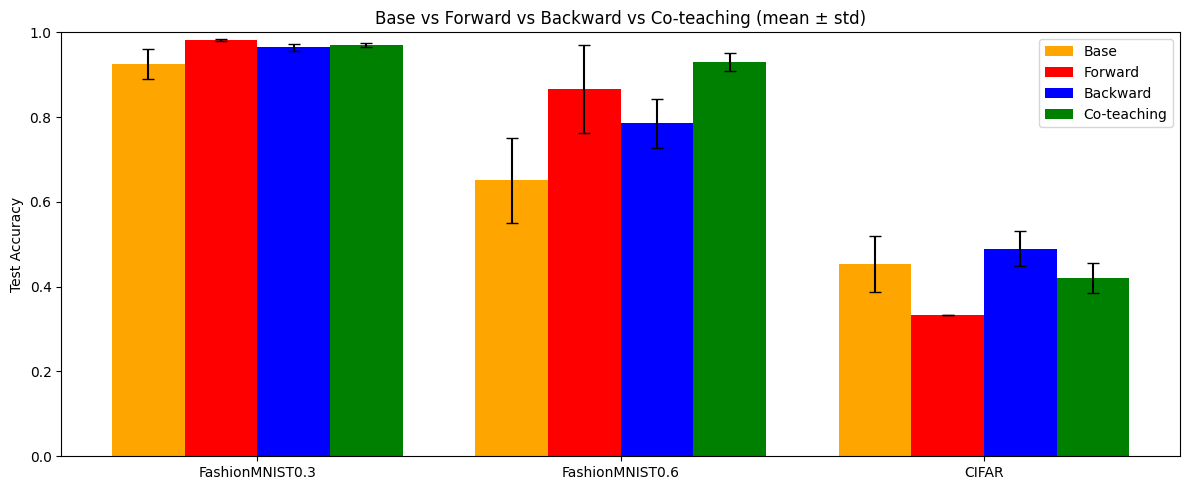

In [ ]:
colors = {
    'Base': 'orange',
    'Forward': 'red',
    'Backward': 'blue',
    'Co-teaching': 'green'
}

metrics, datasets = build_metrics_dict(results_base, results_forward, results_backward, results_coteach)
models = ['Base','Forward','Backward','Co-teaching']

x = np.arange(len(datasets))
width = 0.20

plt.figure(figsize=(12,5))
for k, model in enumerate(models):
    means = [metrics[ds][model][0] for ds in datasets]
    stds  = [metrics[ds][model][1] for ds in datasets]
    plt.bar(x + (k - 3/2)*width, means, width, yerr=stds, capsize=4,
            color=colors[model], label=model)

plt.xticks(x, datasets)
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.0)
plt.title('Base vs Forward vs Backward vs Co-teaching (mean ± std)')
plt.legend()
plt.tight_layout()
plt.show()


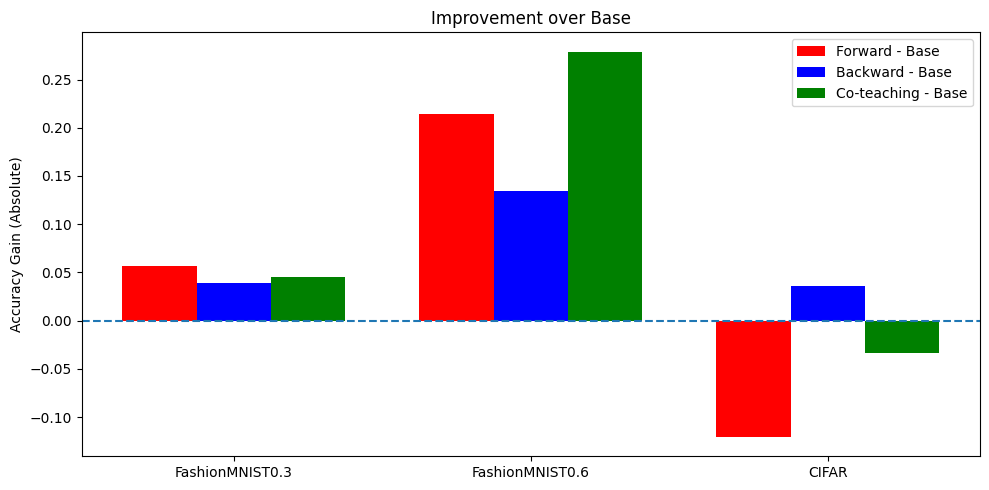

In [ ]:
improve_forward  = []
improve_backward = []
improve_coteach = []

for ds in datasets:
    base_mean = metrics[ds]['Base'][0]
    improve_forward.append(metrics[ds]['Forward'][0]  - base_mean)
    improve_backward.append(metrics[ds]['Backward'][0] - base_mean)
    improve_coteach.append(metrics[ds]['Co-teaching'][0] - base_mean)

x = np.arange(len(datasets))
width = 0.25

plt.figure(figsize=(10,5))
plt.bar(x - width, improve_forward,  width, color=colors['Forward'], label='Forward - Base')
plt.bar(x , improve_backward, width, color=colors['Backward'], label='Backward - Base')
plt.bar(x + width, improve_coteach, width, color=colors['Co-teaching'], label='Co-teaching - Base')
plt.axhline(0.0, linestyle='--')
plt.xticks(x, datasets)
plt.ylabel('Accuracy Gain (Absolute)')
plt.title('Improvement over Base')
plt.legend()
plt.tight_layout()
plt.show()